In [1]:
# %pylab notebook
# %matplotlib notebook

import os, glob

import numpy as np

from scipy.ndimage.filters import convolve

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import rawpy

from datapath import DATA

/var/folders/98/9tkbspjx0_9ggcp3rrpjw10w0000gn/T/ipykernel_878/2445218883.py:8: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
# Colormaps for the RGB Bayer pixels
reds = {'red':    [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)],
         'green': [(0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)]}
greens = {'red':  [(0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)],
         'green': [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)],
         'blue':  [(0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)]}
blues = {'red':   [(0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)],
         'green': [(0.0,  0.0, 0.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.0, 0.0),
                   (1.0,  1.0, 1.0)]}

red_colormap = mcolors.LinearSegmentedColormap('RED', reds)
green_colormap = mcolors.LinearSegmentedColormap('GREEN', greens)
blue_colormap = mcolors.LinearSegmentedColormap('BLUE', blues)

In [3]:
# Utility function to plot the gray image plus 
# the 3 separate Bayer layers on a single figure.
def plot_rgb_panes(gray, red, green, blue, colormap=None, vmin=None, vmax=None, titles=None):
    if titles is None:
        tit = ['All','Red','Green','Blue']
    else:
        tit = titles

    v1 = vmin
    v2 = vmax
    if vmin is not None:
        v1 = vmin
    if vmax is not None:
        v2 = vmax

    fig = plt.figure(figsize=[9,7]) 
    ax = None
    for color, bar, i in zip([gray, red, green, blue], 
                             [cm.gray,red_colormap,green_colormap,blue_colormap], 
                             range(0,4)):
        if ax is None:
            ax = fig.add_subplot(2, 2, i+1)
            if colormap is None:
                ax.set_title(tit[i])    
        else:
            ax1 = fig.add_subplot(2, 2, i+1, sharex=ax, sharey=ax)
            if colormap is None:
                ax1.set_title(tit[i])
                
        bar1 = bar
        if colormap is not None:
            bar1 = colormap
        plt.imshow(color, cmap=bar1, vmin=v1, vmax=v2)
        plt.colorbar()
    plt.show()

In [4]:
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/tests/3200_DSC03659.ARW')

## Raw image

In [5]:
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible

# Note that we aren't subtracting the camera dark level (512 for all channels in Sony images)

Text(0.5, 1.0, 'Gray-scale raw image')

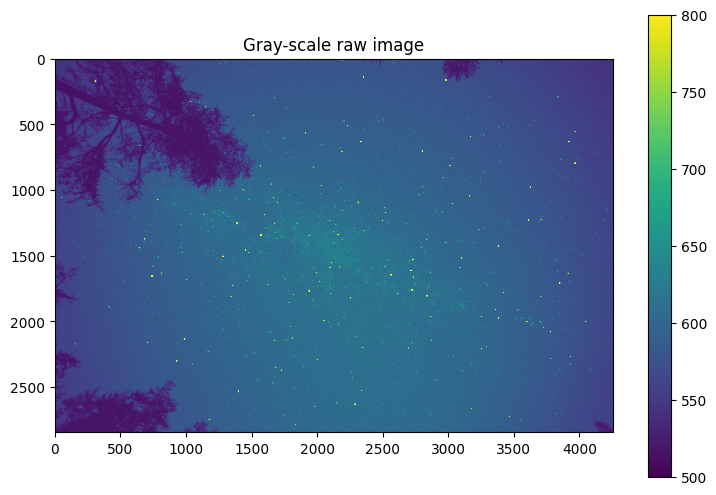

In [ ]:
plt.figure(figsize=[9, 6])
plt.imshow(imarray, vmin=500, vmax=800)
plt.colorbar()
plt.title('Gray-scale raw image')

### An interesting slice of the raw image

In [ ]:
aslice = np.index_exp[1150:1240,1950:2050]

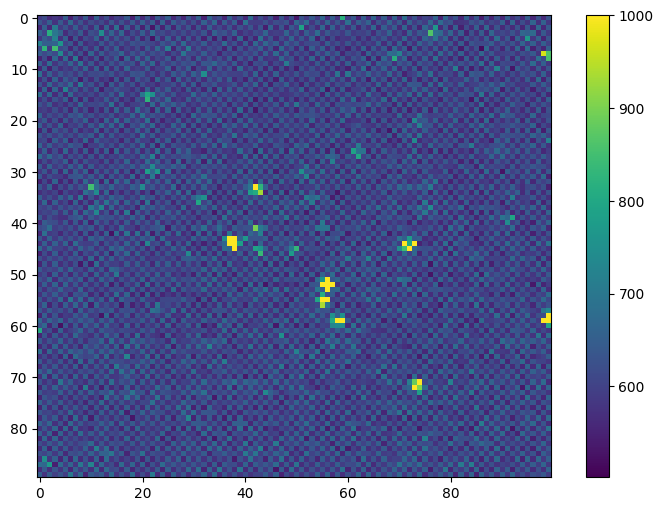

In [8]:
plt.figure(figsize=[9, 6])
plt.imshow(imarray[aslice], vmin=502, vmax=1000)
plt.colorbar()

## Masks to isolate RGB layers from Bayer raw image

In [9]:
colors_array = raw.raw_colors_visible
mask = np.ones(shape=colors_array.shape)

red_mask = np.where(colors_array == 0, 1, 0)

green_mask_1 = np.where(colors_array == 1, 1, 0)
green_mask_2 = np.where(colors_array == 3, 1, 0)
green_mask = green_mask_1 | green_mask_2

blue_mask = np.where(colors_array == 2, 1, 0)

The 3 plots below must be zoomed in in order to display the actual pixels.

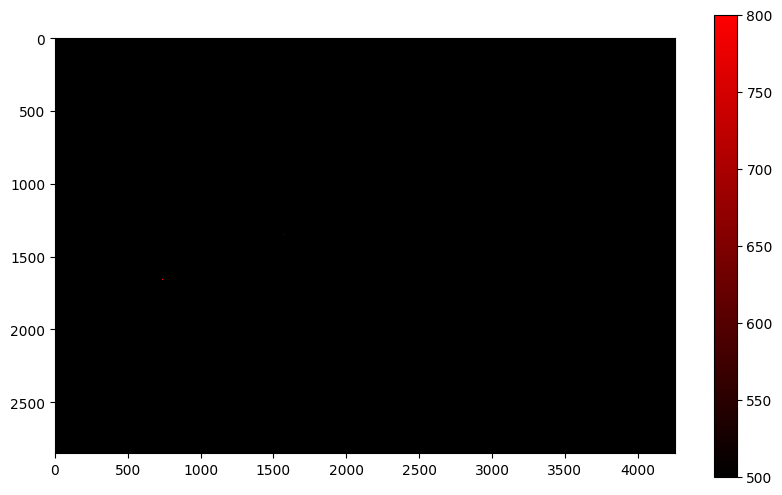

In [10]:
plt.figure(figsize=[10, 6])
plt.imshow(imarray * red_mask, cmap=red_colormap, vmin=500, vmax=800)
plt.colorbar()

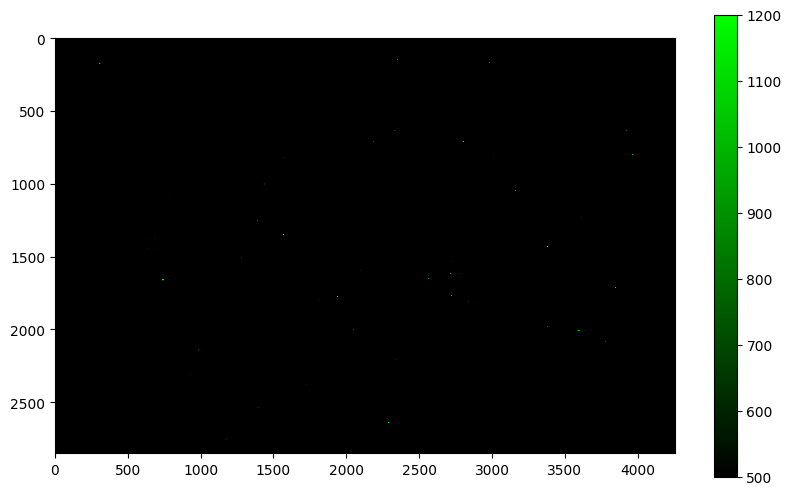

In [11]:
plt.figure(figsize=[10, 6])
plt.imshow(imarray * green_mask, cmap=green_colormap, vmin=500, vmax=1200)
plt.colorbar()

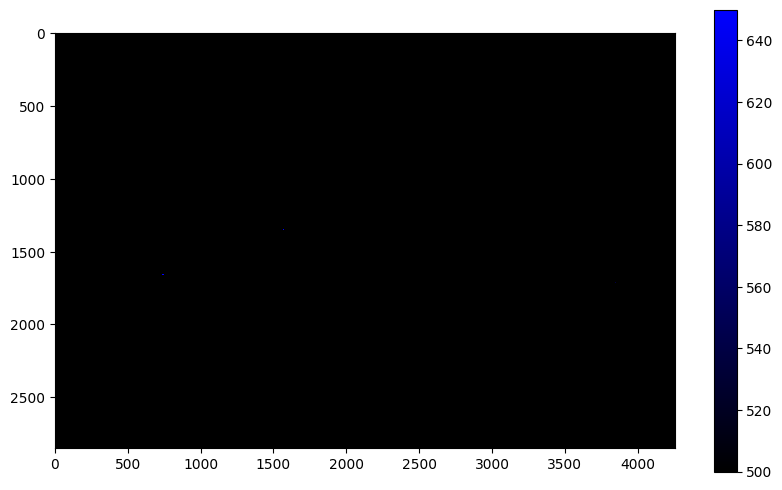

In [12]:
plt.figure(figsize=[10, 6])
plt.imshow(imarray * blue_mask, cmap=blue_colormap, vmin=500, vmax=650)
plt.colorbar()

### Bayer layers displayed together

In [13]:
# Normalize such as to make the 3 layers stand
# out more or less the same. Otherwise the green
# layer dominates the other two.
red_norm = raw.camera_whitebalance[1] / raw.camera_whitebalance[0]
blue_norm = raw.camera_whitebalance[1] / raw.camera_whitebalance[2]
green_norm = 1.

red_norm *= 1.5 # to account for display/eye effects

vmin = 500
vmax = 800

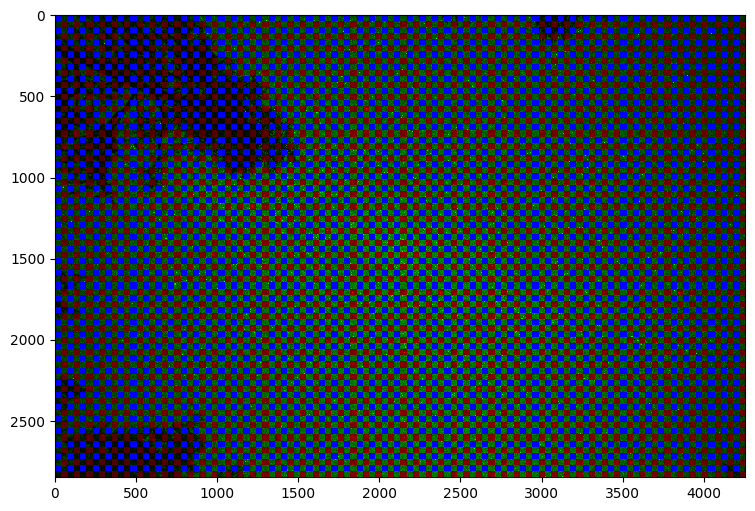

In [14]:
red_ma = np.ma.masked_where(red_mask == 0, imarray)
green_ma = np.ma.masked_where(green_mask == 0, imarray)
blue_ma = np.ma.masked_where(blue_mask == 0, imarray)

fig, ax = plt.subplots(figsize=[9,6])
ax.imshow(red_ma , cmap=red_colormap, interpolation='none', vmin=vmin*red_norm, vmax=vmax*red_norm)
ax.imshow(green_ma , cmap=green_colormap, interpolation='none', vmin=vmin*green_norm, vmax=vmax*green_norm)
ax.imshow(blue_ma , cmap=blue_colormap, interpolation='none', vmin=vmin*blue_norm, vmax=vmax*blue_norm)
plt.show()

### Bayer layers of slice

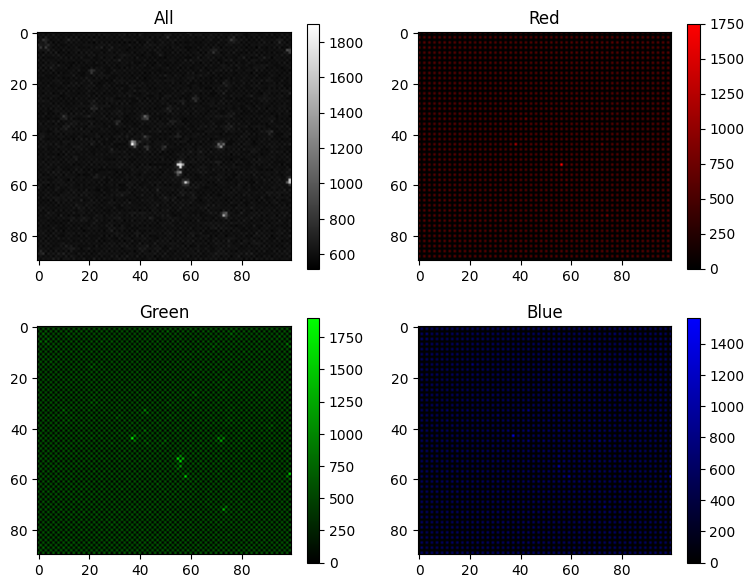

In [15]:
plot_rgb_panes(imarray[aslice], 
               (imarray * red_mask)[aslice], 
               (imarray * green_mask)[aslice], 
               (imarray * blue_mask)[aslice])

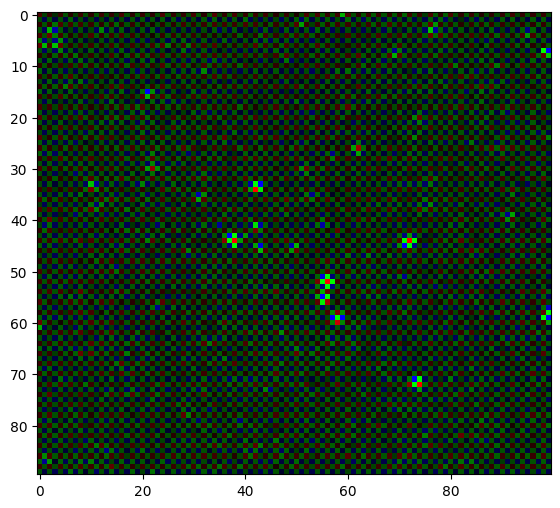

In [16]:
red_ma = np.ma.masked_where(red_mask[aslice] == 0, imarray[aslice])
green_ma = np.ma.masked_where(green_mask[aslice] == 0, imarray[aslice])
blue_ma = np.ma.masked_where(blue_mask[aslice] == 0, imarray[aslice])

fig, ax = plt.subplots(figsize=[9,6])
ax.imshow(red_ma , cmap=red_colormap, interpolation='none', vmin=vmin, vmax=vmax)
ax.imshow(green_ma , cmap=green_colormap, interpolation='none', vmin=vmin, vmax=vmax*1.2)
ax.imshow(blue_ma , cmap=blue_colormap, interpolation='none', vmin=vmin, vmax=vmax)
plt.show()

## Standard de-Bayerization

In [17]:
# rgb = raw.postprocess()
rgb = raw.postprocess(
    demosaic_algorithm=rawpy.DemosaicAlgorithm.LINEAR,
    output_bps=16,
    gamma=(1,1), 
    use_camera_wb=False,
    use_auto_wb=False,
    no_auto_bright=True, 
    no_auto_scale=True,
    output_color=rawpy.ColorSpace.raw
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


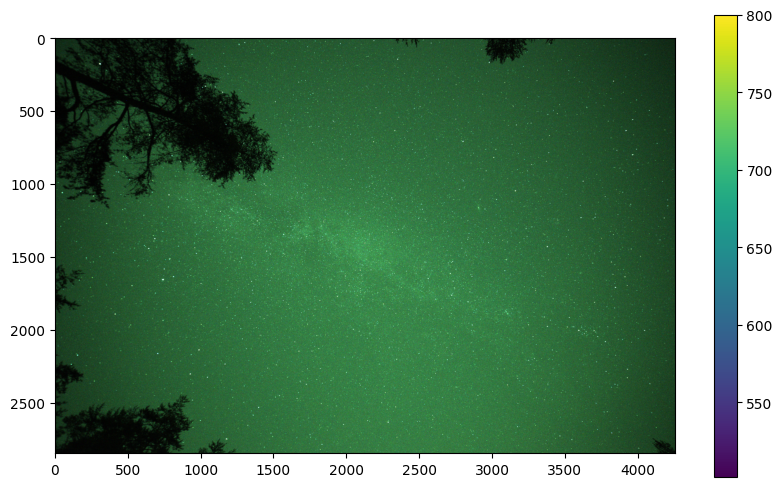

In [18]:
plt.figure(figsize=[10, 6])
plt.imshow(rgb, vmin=502, vmax=800)
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


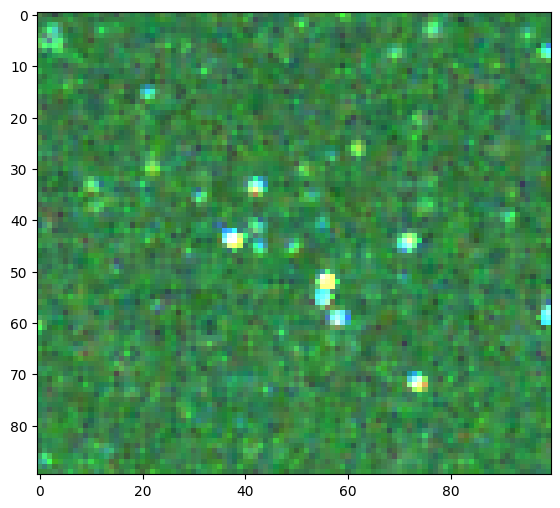

In [19]:
plt.figure(figsize=[10, 6])
plt.imshow(rgb[aslice])

### Display de-Bayerized RGB layers separately

In [20]:
red1 = rgb[::,::,0]
green1 = rgb[::,::,1]
blue1 = rgb[::,::,2]

# Correct white balance only in case of default postproceesing.
# red2 = red1 * raw.camera_whitebalance[0] / raw.camera_whitebalance[1]
red2 = red1 
green2 = green1
# blue2 = blue1 * raw.camera_whitebalance[2] / raw.camera_whitebalance[1]
blue2 = blue1 

# empirical gray image that maybe should be
# good for finding star image positions.
gray2 = red2/3. + green2/3. + blue2/3.

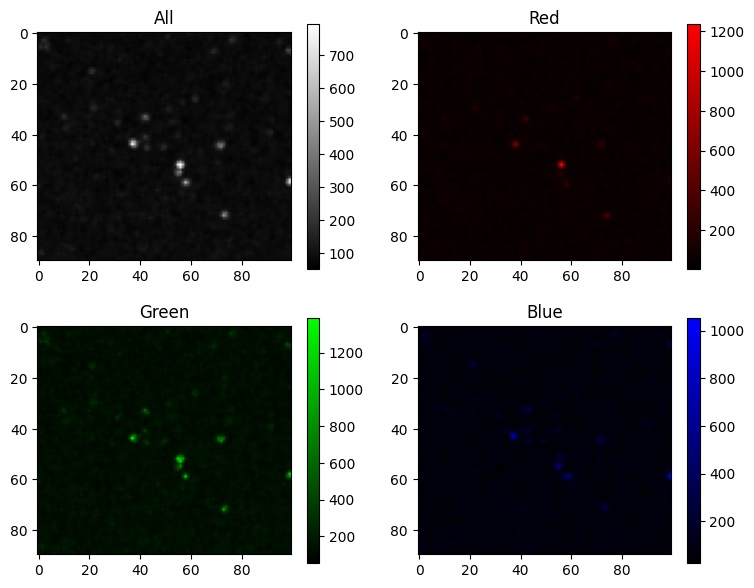

In [21]:
plot_rgb_panes(gray2[aslice], red2[aslice], green2[aslice], blue2[aslice])

## Linear de-Bayerization algorithm

In [22]:
H_G = np.array(
    [[0, 1, 0],
     [1, 4, 1],
     [0, 1, 0]]) / 4
H_RB = np.array(
    [[1, 2, 1],
     [2, 4, 2],
     [1, 2, 1]]) / 4

red = convolve(imarray * red_mask, H_RB) - 512
green = convolve(imarray * green_mask, H_G) - 512
blue = convolve(imarray * blue_mask, H_RB) - 512

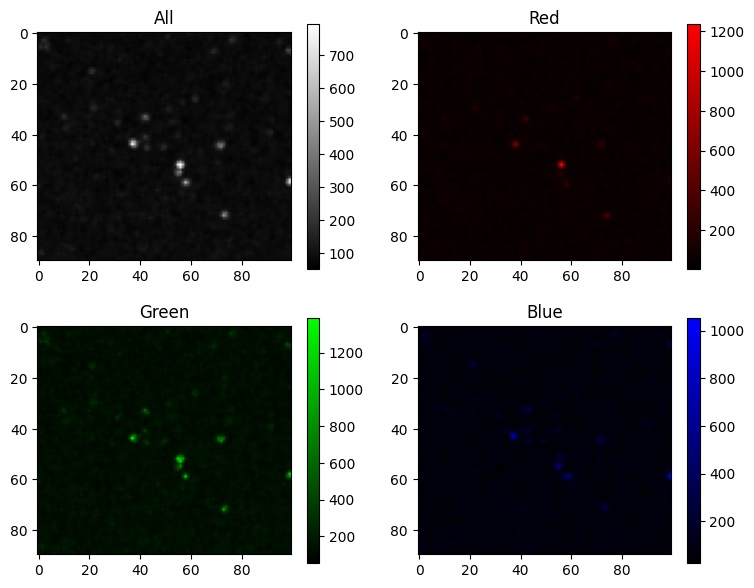

In [23]:
gray = red/3. + green/3. + blue/3.
plot_rgb_panes(gray[aslice], red[aslice], green[aslice], blue[aslice])

The difference between the two de-bayred images shows that the 2 methods we tried are identical to each other.

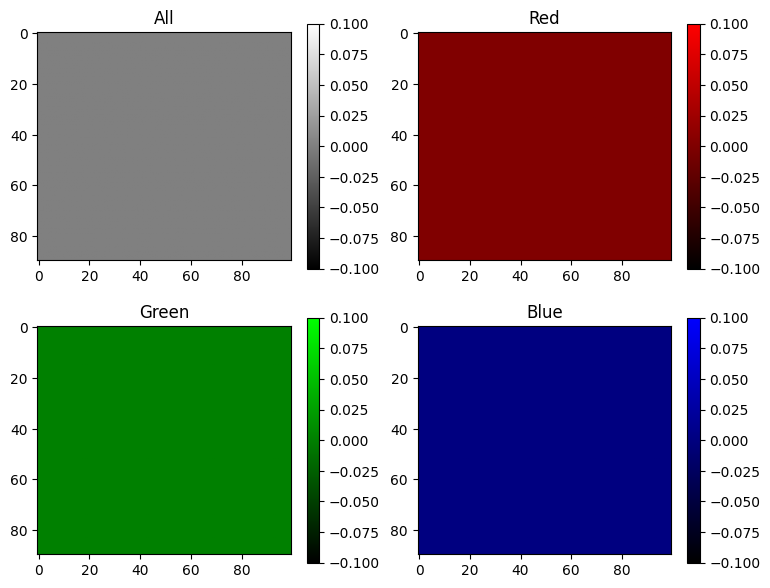

In [24]:
plot_rgb_panes((gray2-gray)[aslice], (red2-red)[aslice], (green2-green)[aslice], (blue2-blue2)[aslice])

## Freeman's modification to linear debayer

It doesn't seem to improve the recovery of star color images. We keep the experiment here for reference only.

In [25]:
# Image differences.
r_g = red - green
b_g = blue - green

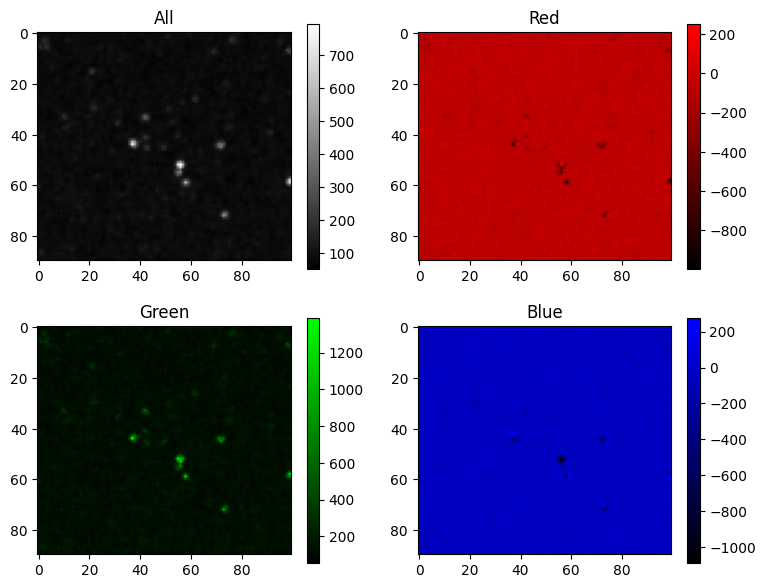

In [26]:
plot_rgb_panes(gray[aslice], r_g[aslice], green[aslice], b_g[aslice])

In [27]:
import scipy.ndimage as nd

In [28]:
# Median-filter the differences 
size = (3,3)
r_g_med = nd.median_filter(r_g, size=size)
b_g_med = nd.median_filter(b_g, size=size)

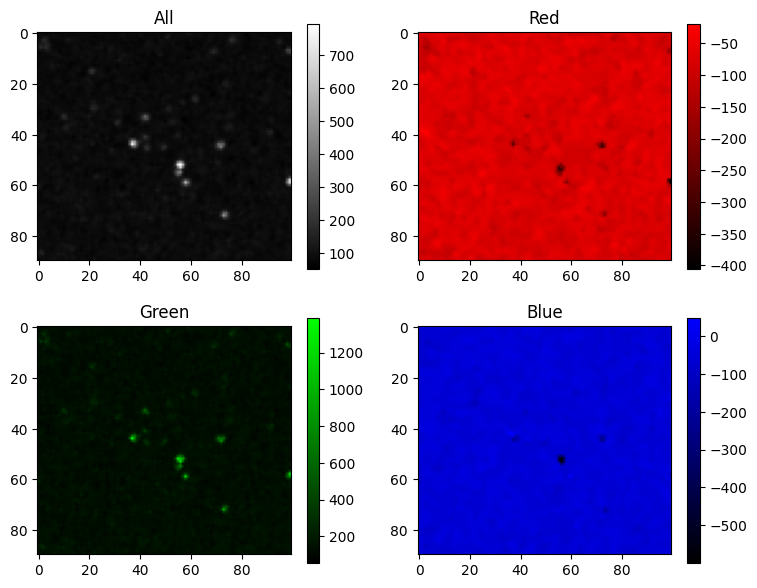

In [29]:
plot_rgb_panes(gray[aslice], r_g_med[aslice], green[aslice], b_g_med[aslice])

In [30]:
# Recover R and B images.
red_final = r_g_med + red
blue_final = b_g_med + blue

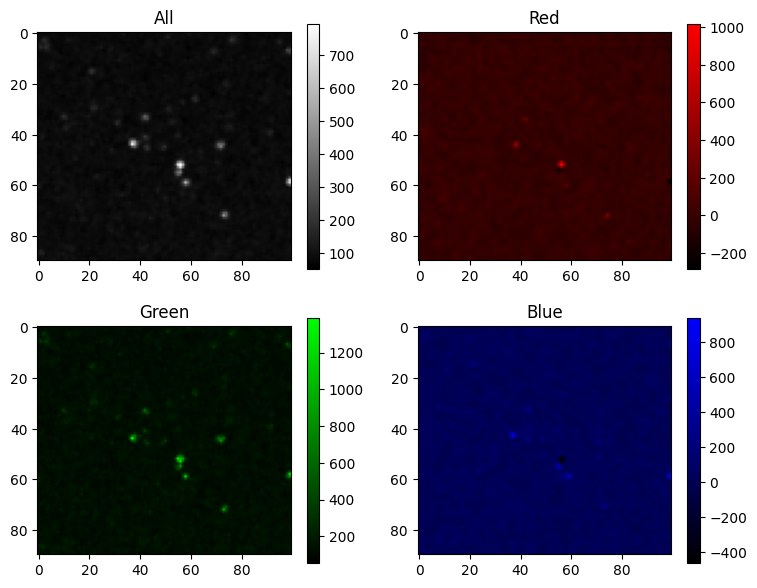

In [31]:
plot_rgb_panes(gray[aslice], red_final[aslice], green[aslice], blue_final[aslice])

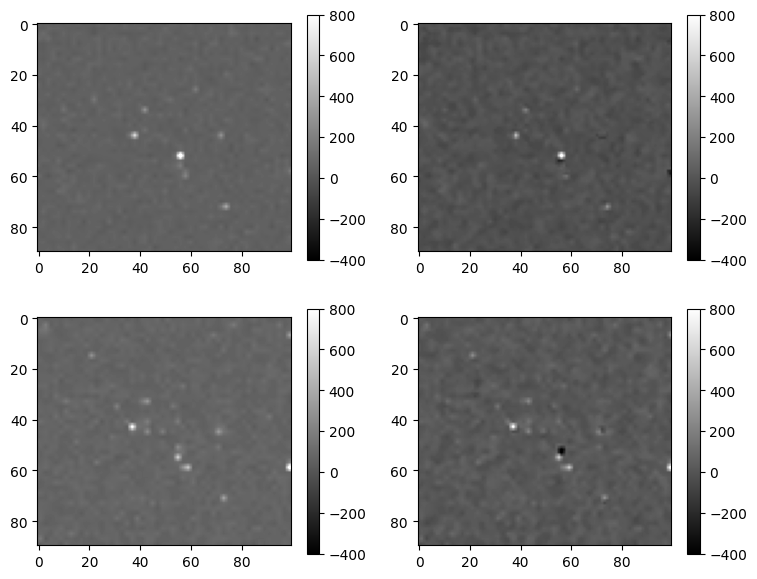

In [32]:
plot_rgb_panes(red[aslice], red_final[aslice], blue[aslice], blue_final[aslice], colormap=cm.gray,
              vmin=-400., vmax=800., titles=['Red','Red Freeman','Blue','Blue Freeman'])